In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import sys
import StringIO

%matplotlib inline

In [2]:
from pandas.io.data import DataReader
from datetime import datetime

ms = DataReader('MSFT',  'yahoo', datetime(2011, 1, 1), datetime(2016, 11, 30))
print(ms['Adj Close']).head()


C:\Users\dsinha4\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


Date
2011-01-03    23.727305
2011-01-04    23.820586
2011-01-05    23.744265
2011-01-06    24.439633
2011-01-07    24.253071
Name: Adj Close, dtype: float64


In [3]:
ms.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,28.049999,28.18,27.920000,27.98,53443800,23.727305
2011-01-04,27.940001,28.17,27.850000,28.09,54405600,23.820586
2011-01-05,27.900000,28.01,27.770000,28.00,58998700,23.744265
2011-01-06,28.040001,28.85,27.860001,28.82,88026300,24.439633
2011-01-07,28.639999,28.74,28.250000,28.60,73762000,24.253071


In [4]:
 ms.columns

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close'], dtype='object')

#### News Segmentation

In [5]:
# Print decision tree model 'dt'
def display_dt(model):
    dummy_io = StringIO.StringIO() 
    tree.export_graphviz(model, out_file = dummy_io) 
    graph = pydot.graph_from_dot_data(dummy_io.getvalue()) 
    graph.write_pdf("tree.pdf") 
    print dummy_io.getvalue()

In [6]:
# define column header
#news_header = ['FactSet','Browser','Source', 'DateTime','Headline','Class']

# read dataset
news_df = pd.read_csv('datasets/News - Headlines 30-Nov-16.txt', delimiter='\t') #, names=news_header)
print(news_df.shape)

(5141, 5)


In [7]:
news_df.head()

,FactSet,Browser,Source,Date/Time,Headline
0,FactSet,Browser,PRN,30 Nov '16 07:45 PM,Microsoft announces quarterly dividend
1,FactSet,Browser,TWTR,30 Nov '16 07:51 AM,Twitter - @SEEKINGALPHA_FS: Microsoft made oth...
2,FactSet,Browser,FCSTEV,29 Nov '16 12:24 PM,Microsoft Corp.(MSFT-US) Schedules Barclays Gl...
3,FactSet,Browser,FTH,29 Nov '16 12:00 AM,Can Microsoft get back in the game with AI?
4,FactSet,Browser,PRN,28 Nov '16 11:00 PM,Microsoft HoloLens is coming to Japan


In [8]:
#news_df.tail()

In [9]:
news_df["Class"] = 0
news_df = news_df.dropna()

news_df.tail()

,FactSet,Browser,Source,Date/Time,Headline,Class
5130,FactSet,Browser,FCST,01 Dec '11 03:12 PM,"CORRECTED TRANSCRIPT: Microsoft Corp.(MSFT), C...",0
5131,FactSet,Browser,PRN,01 Dec '11 03:01 AM,Bing Unveils Magical Holiday Calendar Featurin...,0
5132,FactSet,Browser,PRN,01 Dec '11 02:00 AM,Eye on Earth Enables Cloud-Based Environmental...,0
5133,FactSet,Browser,BW,30 Nov '11 11:39 AM,Big Bang LLC Announces Beta Release of the Uni...,0
5134,FactSet,Browser,FIO,30 Nov '11 09:24 AM,Ownership Updates: MICROSOFT CORP COM (MSFT) ...,0


In [10]:
#news_df["Date"] = news_df["Date/Time"]

news_df["Date"] = pd.to_datetime(news_df["Date/Time"])
news_df["Date"] = pd.DatetimeIndex(news_df["Date"]).date

news_df["Headline"] = news_df["Headline"].str.replace('http\S+', ' ')
news_df["Headline"] = news_df["Headline"].str.replace(' @SEEKINGALPHA_FS: ', ' ')
news_df["Headline"] = news_df["Headline"].str.replace('\W+', ' ')
news_df["Headline"] = news_df["Headline"].str.replace('000', '')
news_df["Headline"] = news_df["Headline"].str.replace('Corp', '')
news_df["Headline"] = news_df["Headline"].str.replace('corp', '')
news_df["Headline"] = news_df["Headline"].str.replace('   ', ' ')
news_df["Headline"] = news_df["Headline"].str.replace('  ', ' ')

news_df["text"] = news_df["Headline"].str.lower()
print news_df.head()

   FactSet  Browser  Source            Date/Time  \
0  FactSet  Browser     PRN  30 Nov '16 07:45 PM   
1  FactSet  Browser    TWTR  30 Nov '16 07:51 AM   
2  FactSet  Browser  FCSTEV  29 Nov '16 12:24 PM   
3  FactSet  Browser     FTH  29 Nov '16 12:00 AM   
4  FactSet  Browser     PRN  28 Nov '16 11:00 PM   

                                            Headline  Class        Date  \
0             Microsoft announces quarterly dividend      0  2016-11-30   
1  Twitter Microsoft made other attempts to buy L...      0  2016-11-30   
2  Microsoft MSFT US Schedules Barclays Global Te...      0  2016-11-29   
3        Can Microsoft get back in the game with AI       0  2016-11-29   
4              Microsoft HoloLens is coming to Japan      0  2016-11-28   

                                                text  
0             microsoft announces quarterly dividend  
1  twitter microsoft made other attempts to buy l...  
2  microsoft msft us schedules barclays global te...  
3        can mic

In [11]:
news_df.describe()

,Class
count,5132.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


range of post lengths: 94 - 2
mean of post lengths: 12.999025721


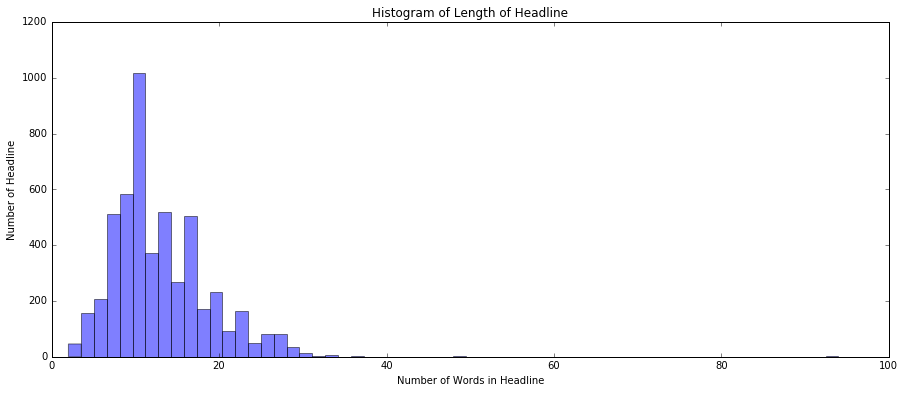

In [12]:
#Break each posts into words and count the number of words
lengths = news_df['text'].apply(lambda x: len(str(x).split(' ')))

print 'range of post lengths:', np.max(lengths), '-', np.min(lengths)
print 'mean of post lengths:', np.mean(lengths)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Histogram of the word counts in each post
ax.hist(lengths, color='blue', bins=60, alpha=0.5)

ax.set_xlabel('Number of Words in Headline')
ax.set_ylabel('Number of Headline')
ax.set_title('Histogram of Length of Headline')

plt.show()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

#Create a text vectorizer (turns text into array of numbers)
#using a common list of English stop words
vectorizer = CountVectorizer(stop_words='english', min_df=1)

#Get all the text from data
corpus = news_df['text'].str.lower()

print corpus

#Turn each text into an array of word counts
x = vectorizer.fit_transform(corpus)
x = x.toarray()

#Get the names of all the words we're counting
feature_names = vectorizer.get_feature_names()

print 'data shape:', x.shape
print 'some features:', feature_names[0:10]

0                  microsoft announces quarterly dividend
1       twitter microsoft made other attempts to buy l...
2       microsoft msft us schedules barclays global te...
3             can microsoft get back in the game with ai 
4                   microsoft hololens is coming to japan
5                streetaccount m a summary week of 21 nov
6       twitter microsoft escalating emphasis on cloud...
7       generali and microsoft announce a partnership ...
8       simplilearn partners with microsoft india to t...
9       twitter microsoft launches office 365 in 10 ne...
10      twitter linkedin microsoft merger expected to ...
11      eu expected to clear microsoft s acquisition o...
12      the so called microsoft scam got this st peter...
13      these are 3 reasons not to use microsoft s new...
14      twitter msftnews at digigirlz event microsoft ...
15      microsoft is looking to build quantum computer...
16      macbook pro 2016 release date news update micr...
17      twitte

In [14]:
#Number of top words
n = 30

#Count the number of time each word occurs in the entire dataset
word_freq = x.sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Print the top n words and their frequencies
print top_words

[(4054, u'microsoft'), (1214, u'msft'), (832, u'corp'), (593, u'emirates'), (469, u'windows'), (348, u'new'), (346, u'dir'), (328, u'news'), (310, u'cloud'), (305, u'united'), (304, u'announces'), (303, u'north'), (298, u'african'), (298, u'agency'), (297, u'arab'), (297, u'middle'), (296, u'east'), (296, u'newspapers'), (295, u'wam'), (273, u'twitter'), (237, u'earnings'), (224, u'2012'), (224, u'et'), (212, u'acquires'), (202, u'ownership'), (196, u'report'), (189, u'updates'), (185, u'files'), (182, u'end'), (172, u'period')]


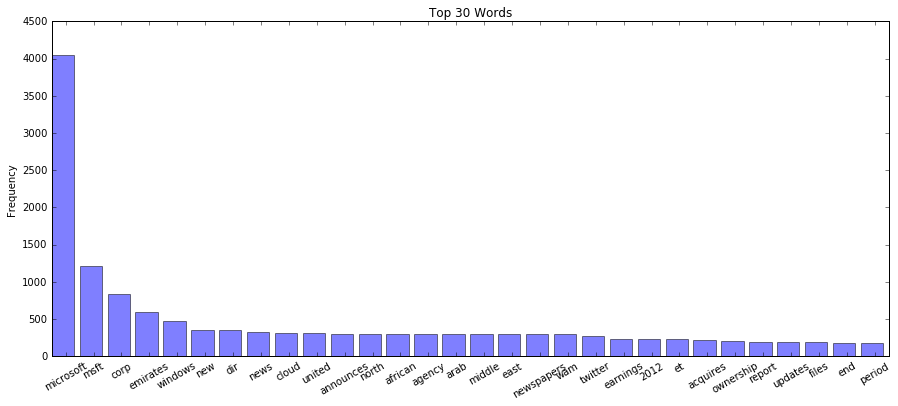

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5
#Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(n) + ' Words')

#Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

In [16]:
news_df['Headline'].str.contains('dividend').head()

0     True
1    False
2    False
3    False
4    False
Name: Headline, dtype: bool

In [17]:
## positive news tags
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('upgrade',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('partnership',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('buy',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('to buy',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('acquisition',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('launch',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('adds',na=False)) ] = 1

news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('unveil',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('ramp',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('soars',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('expands',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('rolls out',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('surpass',na=False)) ] = 1

news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('jumps',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('dividend',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('hit record',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('boost',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('strong',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('increase',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('acquire',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('acquiring',na=False)) ] = 1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('positiv',na=False)) ] = 1


## negative news tags
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('downgrade',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('sells',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('Microsoft scam',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('take on Microsoft',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('battle',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('disposes',na=False)) ] = -1

news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('face complication',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('cuts',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('late',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('fired',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('late',na=False)) ] = -1

news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('to sell',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('ripped off',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('estimates reduce',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('estimates lower',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('layoffs',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('plans to cut',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('fine',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('loses',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('target decreased',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('beating microsoft',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('to close',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('scam',na=False)) ] = -1

news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('drop',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('cancelled',na=False)) ] = -1
news_df["Class"].ix[(news_df['text'].str.contains('microsoft',na=False) & news_df['text'].str.contains('decline',na=False)) ] = -1

news_df.groupby(['Class'])['text'].count()

C:\Users\dsinha4\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Class
-1     366
 0    4050
 1     716
Name: text, dtype: int64

In [18]:
#Encode the class labels (Neg, Pos) as numbers
y = news_df['Class'].values
#x = news_df[0:5].values

In [19]:
#Print the number of comments in each class
print 'number of negative news:', len(y[y == -1])
print 'number of positive news:', len(y[y == 1])
print 'number of neutral news:', len(y[y == 0])

number of negative news: 366
number of positive news: 716
number of neutral news: 4050


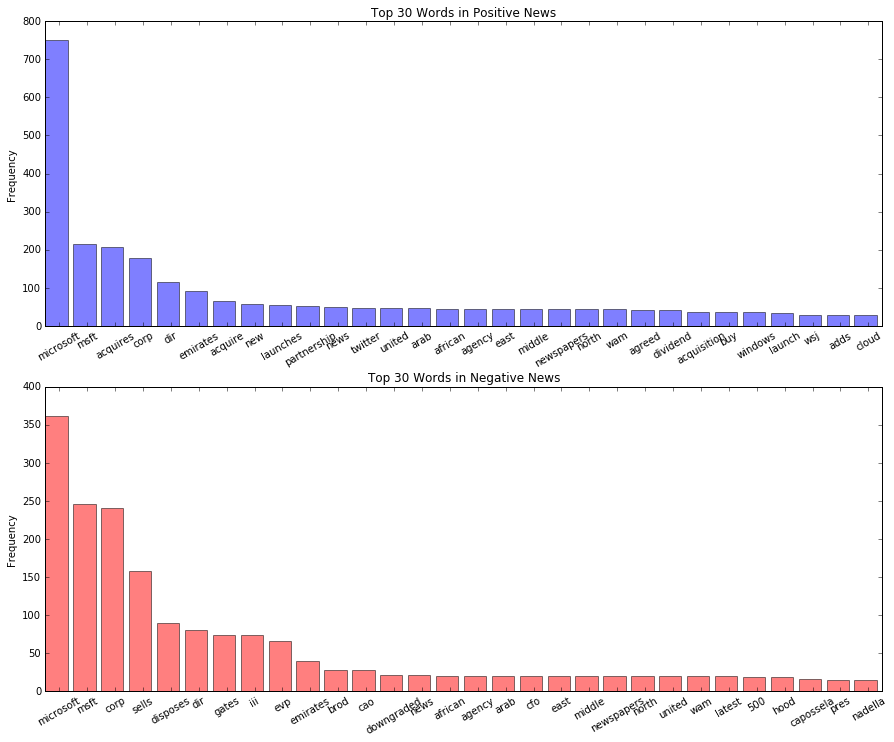

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5

#Count the number of time each word occurs in the positive posts
word_freq = x[y == 1].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Bar plot of the frequencies of the top words
ax[0].bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax[0].set_ylabel('Frequency')
ax[0].set_title('Top ' + str(n) + ' Words in Positive News')

#Label the bars with the top words
ax[0].set_xticks(indices + width)
ax[0].set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax[0].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

#Count the number of time each word occurs in the negative posts
word_freq = x[y < 0].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Bar plot of the frequencies of the top words
ax[1].bar(indices, [word[0] for word in top_words], color='red', alpha=0.5)

ax[1].set_ylabel('Frequency')
ax[1].set_title('Top ' + str(n) + ' Words in Negative News')

#Label the bars with the top words
ax[1].set_xticks(indices + width)
ax[1].set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax[1].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

In [21]:
# Train/test split
n_samples = len(x)
train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

x_train = x[train_indices]
y_train = y[train_indices]

x_test = x[~train_indices]
y_test = y[~train_indices]

#Generate array of L2 regularization parameters
regularization = 10.**np.arange(-10, 5)

#Fit logistic model with cross validation to select the optimal regularization parameter
logistic = LogRegCV(cv=3, 
                    penalty='l2', 
                    Cs=regularization, 
                    solver='liblinear', 
                    n_jobs=2)
logistic.fit(x_train, y_train)

#Print results
print 'Accuracy on overall test set:', logistic.score(x_test, y_test)
print 'Accuracy on class -1 in test set:', logistic.score(x_test[y_test == -1], y_test[y_test == -1])
print 'Accuracy on class 1 in test set:', logistic.score(x_test[y_test == 1], y_test[y_test == 1])

Accuracy on overall test set: 0.966411314084
Accuracy on class -1 in test set: 0.839694656489
Accuracy on class 1 in test set: 0.886639676113


Above accuracy is pretty good, and it looks like we do equally well on predicting negative news and predicting positive news. 

Verify what happens when we remove words that occur with high frequency in each post: that is we set a threshhold, `max_df`, and remove words from posts that occur more that `max_df` number of times. We will try around with a couple of choices for `max_df` and see if it improves our prediction.

In [22]:
#This function computes the accuracy of logistic regression given cut-offs, min_df, max_df
def vectorize_classify(min_df, max_df, trials, x, y):
    #Create a text vectorizer, removing words with frequency less than min_df or
    #greater than max_df
    vectorizer = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df)
    #Transform our text into arrays of numbers
    corpus = news_df['text'].values
    x = vectorizer.fit_transform(corpus)
    x = x.toarray()
    
    #Record overall accuracy rate, accuracy on class 1 and class 0
    overall_acc = []
    class_1_acc = []
    class_0_acc = []
    
    
    n_samples = len(x)
    
    #Perform logistic regression on a handful of train/test splits
    for i in range(trials):
        #Print progress
        sys.stdout.write("\r{0}% completed".format((float(i + 1)/trials)*100))
        sys.stdout.flush()
        
        # Train/test split
        train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

        x_train = x[train_indices]
        y_train = y[train_indices]

        x_test = x[~train_indices]
        y_test = y[~train_indices]

        #Generate array of L2 regularization parameters
        regularization = 10. ** np.arange(-10, 5)

        #Fit logistic model
        logistic = LogRegCV(cv=5, 
                            penalty='l2', 
                            Cs=regularization, 
                            solver='liblinear', 
                            n_jobs=2)
        logistic.fit(x_train, y_train)
        
        overall_acc.append(logistic.score(x_test, y_test))
        class_0_acc.append(logistic.score(x_test[y_test == -1], y_test[y_test == -1]))
        class_1_acc.append(logistic.score(x_test[y_test == 1], y_test[y_test == 1]))

    return (np.mean(overall_acc), 
            np.mean(class_0_acc),
            np.mean(class_1_acc))

In [23]:
min_df = 1
max_df = 6000
trials = 10
overall, class_0, class_1 = vectorize_classify(min_df, max_df, trials, x, y)
print '\nMin frequency, max frequency:', min_df, ',', max_df
print 'Accuracy on overall test set:', overall
print 'Accuracy on class -1 in test set:', class_0
print 'Accuracy on class 1 in test set:', class_1

100.0% completed
Min frequency, max frequency: 1 , 6000
Accuracy on overall test set: 0.966138846647
Accuracy on class -1 in test set: 0.827617968938
Accuracy on class 1 in test set: 0.895864467495


In [24]:
min_df = 1
max_df = 100
trials = 10
overall, class_0, class_1 = vectorize_classify(min_df, max_df, trials, x, y)
print '\nMin frequency, max frequency:', min_df, ',', max_df
print 'Accuracy on overall test set:', overall
print 'Accuracy on class -1 in test set:', class_0
print 'Accuracy on class 1 in test set:', class_1

100.0% completed
Min frequency, max frequency: 1 , 100
Accuracy on overall test set: 0.922723335076
Accuracy on class -1 in test set: 0.749597003462
Accuracy on class 1 in test set: 0.71894052109


Setting max_df to be 100 impacts the accuracy. Using max_df of 6000 gives the best accuracy


In [33]:
## Write the output to a csv file
header = ["Date", "Class"]
news_df.to_csv('datasets/msft_news.csv', columns = header)

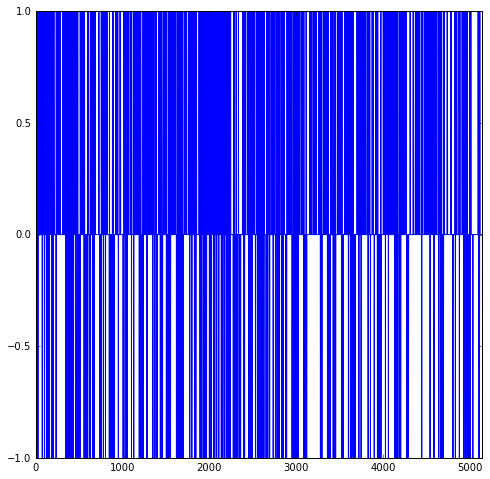

In [26]:
## plot the class
df = news_df
df['Class'].plot(figsize=(8, 8))


In [27]:
## Add Date column
#ms["Date"] = ms.index
ms.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,28.049999,28.18,27.920000,27.98,53443800,23.727305
2011-01-04,27.940001,28.17,27.850000,28.09,54405600,23.820586
2011-01-05,27.900000,28.01,27.770000,28.00,58998700,23.744265
2011-01-06,28.040001,28.85,27.860001,28.82,88026300,24.439633
2011-01-07,28.639999,28.74,28.250000,28.60,73762000,24.253071


In [28]:
# Select relevant columns from the data frame to merge with stock price
df = news_df.ix[:, 'Class':'Date']

df.index = df.Date
df.head()

,Class,Date
Date,,
2016-11-30,1,2016-11-30
2016-11-30,1,2016-11-30
2016-11-29,0,2016-11-29
2016-11-29,0,2016-11-29
2016-11-28,0,2016-11-28


In [29]:
msft = ms.join(df, rsuffix='_y')
msft.head()

,Open,High,Low,Close,Volume,Adj Close,Class,Date
2011-01-03,28.049999,28.18,27.920000,27.98,53443800,23.727305,NaN,NaN
2011-01-04,27.940001,28.17,27.850000,28.09,54405600,23.820586,NaN,NaN
2011-01-05,27.900000,28.01,27.770000,28.00,58998700,23.744265,NaN,NaN
2011-01-06,28.040001,28.85,27.860001,28.82,88026300,24.439633,NaN,NaN
2011-01-07,28.639999,28.74,28.250000,28.60,73762000,24.253071,NaN,NaN


In [30]:
msft.tail()

,Open,High,Low,Close,Volume,Adj Close,Class,Date
2016-11-28,60.340000,61.02,60.209999,60.610001,20603800,60.610001,0.0,2016-11-28
2016-11-29,60.650002,61.41,60.520000,61.090000,22010800,61.090000,0.0,2016-11-29
2016-11-29,60.650002,61.41,60.520000,61.090000,22010800,61.090000,0.0,2016-11-29
2016-11-30,60.860001,61.18,60.220001,60.259998,33783900,60.259998,1.0,2016-11-30
2016-11-30,60.860001,61.18,60.220001,60.259998,33783900,60.259998,1.0,2016-11-30


In [36]:
msft = msft.ix[:, :'Class']
msft['Class'].fillna(0, inplace=True)
msft = msft.drop_duplicates()
print msft.shape

msft.head()

(2038, 7)


,Open,High,Low,Close,Volume,Adj Close,Class
2011-01-03,28.049999,28.18,27.920000,27.98,53443800,23.727305,0.0
2011-01-04,27.940001,28.17,27.850000,28.09,54405600,23.820586,0.0
2011-01-05,27.900000,28.01,27.770000,28.00,58998700,23.744265,0.0
2011-01-06,28.040001,28.85,27.860001,28.82,88026300,24.439633,0.0
2011-01-07,28.639999,28.74,28.250000,28.60,73762000,24.253071,0.0


In [37]:
# Train/test split

x = msft.ix[:, :'Adj Close'].values
y = msft.ix[:, -1].values

n_samples = len(x)
train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

x_train = x[train_indices]
y_train = y[train_indices]

x_test = x[~train_indices]
y_test = y[~train_indices]

#Generate array of L2 regularization parameters
regularization = 10.**np.arange(-10, 5)

#Fit logistic model with cross validation to select the optimal regularization parameter
logistic = LogRegCV(cv=3, 
                    penalty='l2', 
                    Cs=regularization, 
                    solver='newton-cg', 
                    n_jobs=2)
logistic.fit(x_train, y_train)

#Print results
print 'Accuracy on overall test set:', logistic.score(x_test, y_test)
print 'Accuracy on class -1 in test set:', logistic.score(x_test[y_test == -1], y_test[y_test == -1])
print 'Accuracy on class 1 in test set:', logistic.score(x_test[y_test == 1], y_test[y_test == 1])

Accuracy on overall test set: 0.692307692308
Accuracy on class -1 in test set: 0.0
Accuracy on class 1 in test set: 0.0


# ???? Need to use multi-class SVM